In [1]:
from pathlib import Path
import random
import os
from importlib import reload

import warnings
# Ignore PyTorch's KLDivLoss warning
warnings.simplefilter("ignore", category=UserWarning, lineno=2949)

import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import torch
from tqdm.auto import tqdm

In [36]:
from utils.config import BASE_PATH, SPEC_DIR, DEVICE
from utils.data_handling import metadata_df

class_names = ["seizure", "lpd", "gpd", "lrda", "grda", "other"]

metadata = metadata_df("train")
display(metadata.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,eeg_npy_path,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,data/eegs_npy/train_spectrograms/353733npy,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,data/eegs_npy/train_spectrograms/353733npy,0


In [3]:
DEVICE

'cuda'

In [17]:
from utils import SpectrogramDataset
valid_frac = 0.1
num_unique_spectrograms = metadata.spectrogram_id.unique().shape[0]
valid_num = round(valid_frac * num_unique_spectrograms)
print(f"{num_unique_spectrograms} unique spectrograms, using {valid_num} for validation set.")

rng = np.random.default_rng(seed=4)
valid_set = rng.choice(metadata.spectrogram_id.unique(), size=valid_num, replace=False)
metadata_train = metadata[~metadata.spectrogram_id.isin(valid_set)]
metadata_valid = metadata[metadata.spectrogram_id.isin(valid_set)]
print(f"{len(metadata_train)} training items, {len(metadata_valid)} validation items.")

train_dset = SpectrogramDataset(metadata_train, preloaded=True)
valid_dset = SpectrogramDataset(metadata_valid, preloaded=True)


11138 unique spectrograms, using 1114 for validation set.
95346 training items, 11454 validation items.


In [18]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dset, batch_size=32)
valid_loader = DataLoader(valid_dset, batch_size=32)

In [16]:
from utils.models import Spectrogram_EfficientNet

model = Spectrogram_EfficientNet(frozen=False, download=False).to(DEVICE)
model.load_state_dict(torch.load("models/spectrogram_efficientnet_b0_SGD_batch_size_16_full_dataset_10000_batches.pt"))

<All keys matched successfully>

In [47]:
metadata_valid.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,eeg_npy_path,class_label
69,374504640,0,0.0,3452193,0,0.0,474823595,29847,GRDA,0,0,2,0,8,2,data/train_eegs/374504640.parquet,data/train_spectrograms/3452193.parquet,data/spectrograms_npy/train_spectrograms/34521...,data/eegs_npy/train_spectrograms/3452193npy,4
70,374504640,1,12.0,3452193,1,12.0,2517564994,29847,GRDA,0,0,2,0,8,2,data/train_eegs/374504640.parquet,data/train_spectrograms/3452193.parquet,data/spectrograms_npy/train_spectrograms/34521...,data/eegs_npy/train_spectrograms/3452193npy,4
71,374504640,2,14.0,3452193,2,14.0,2623655777,29847,GRDA,0,0,2,0,8,2,data/train_eegs/374504640.parquet,data/train_spectrograms/3452193.parquet,data/spectrograms_npy/train_spectrograms/34521...,data/eegs_npy/train_spectrograms/3452193npy,4
72,374504640,3,18.0,3452193,3,18.0,2600881827,29847,GRDA,0,0,2,0,8,2,data/train_eegs/374504640.parquet,data/train_spectrograms/3452193.parquet,data/spectrograms_npy/train_spectrograms/34521...,data/eegs_npy/train_spectrograms/3452193npy,4
73,374504640,4,20.0,3452193,4,20.0,3499448952,29847,GRDA,0,0,2,0,8,2,data/train_eegs/374504640.parquet,data/train_spectrograms/3452193.parquet,data/spectrograms_npy/train_spectrograms/34521...,data/eegs_npy/train_spectrograms/3452193npy,4


In [31]:
preds = []
for batch in valid_loader:
    preds_batch = model(next(iter(train_loader))[0].to(DEVICE)).exp().detach().cpu().numpy()
    preds.append(preds_batch)

preds = np.vstack(preds)
preds.shape

(11456, 6)

In [32]:
preds_df = pd.DataFrame(preds, columns=["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"])
preds_df.head()

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,0.753966,0.022153,0.002445,0.114710,0.000301,0.106425
1,0.921157,0.003360,0.000539,0.043935,0.000044,0.030965
2,0.919524,0.004329,0.000683,0.039819,0.000055,0.035591
3,0.962502,0.001124,0.000183,0.020938,0.000013,0.015239
4,0.987107,0.000460,0.000041,0.007594,0.000002,0.004796


In [46]:
true_votes = metadata_valid[[x+"_vote" for x in class_names]].copy()
num_voters = true_votes.sum(axis=1)
for col in true_votes.columns:
    true_votes[col] /= num_voters
valid_with_preds = pd.merge(true_votes, preds_df,
                            left_index=True, right_index=True,
                            suffixes=("_true", "_pred"))
valid_with_preds["num_voters"] = num_voters

valid_with_preds.head()

,seizure_vote_true,lpd_vote_true,gpd_vote_true,lrda_vote_true,grda_vote_true,other_vote_true,seizure_vote_pred,lpd_vote_pred,gpd_vote_pred,lrda_vote_pred,grda_vote_pred,other_vote_pred,num_voters
69,0.0,0.0,0.166667,0.0,0.666667,0.166667,0.968807,0.000660,0.000082,0.019530,0.000005,0.010916,12
70,0.0,0.0,0.166667,0.0,0.666667,0.166667,0.966996,0.001034,0.000090,0.018388,0.000008,0.013484,12
71,0.0,0.0,0.166667,0.0,0.666667,0.166667,0.979825,0.001317,0.000143,0.010212,0.000004,0.008498,12
72,0.0,0.0,0.166667,0.0,0.666667,0.166667,0.965741,0.002962,0.000664,0.010490,0.000021,0.020122,12
73,0.0,0.0,0.166667,0.0,0.666667,0.166667,0.025476,0.007821,0.268694,0.007854,0.077096,0.613060,12


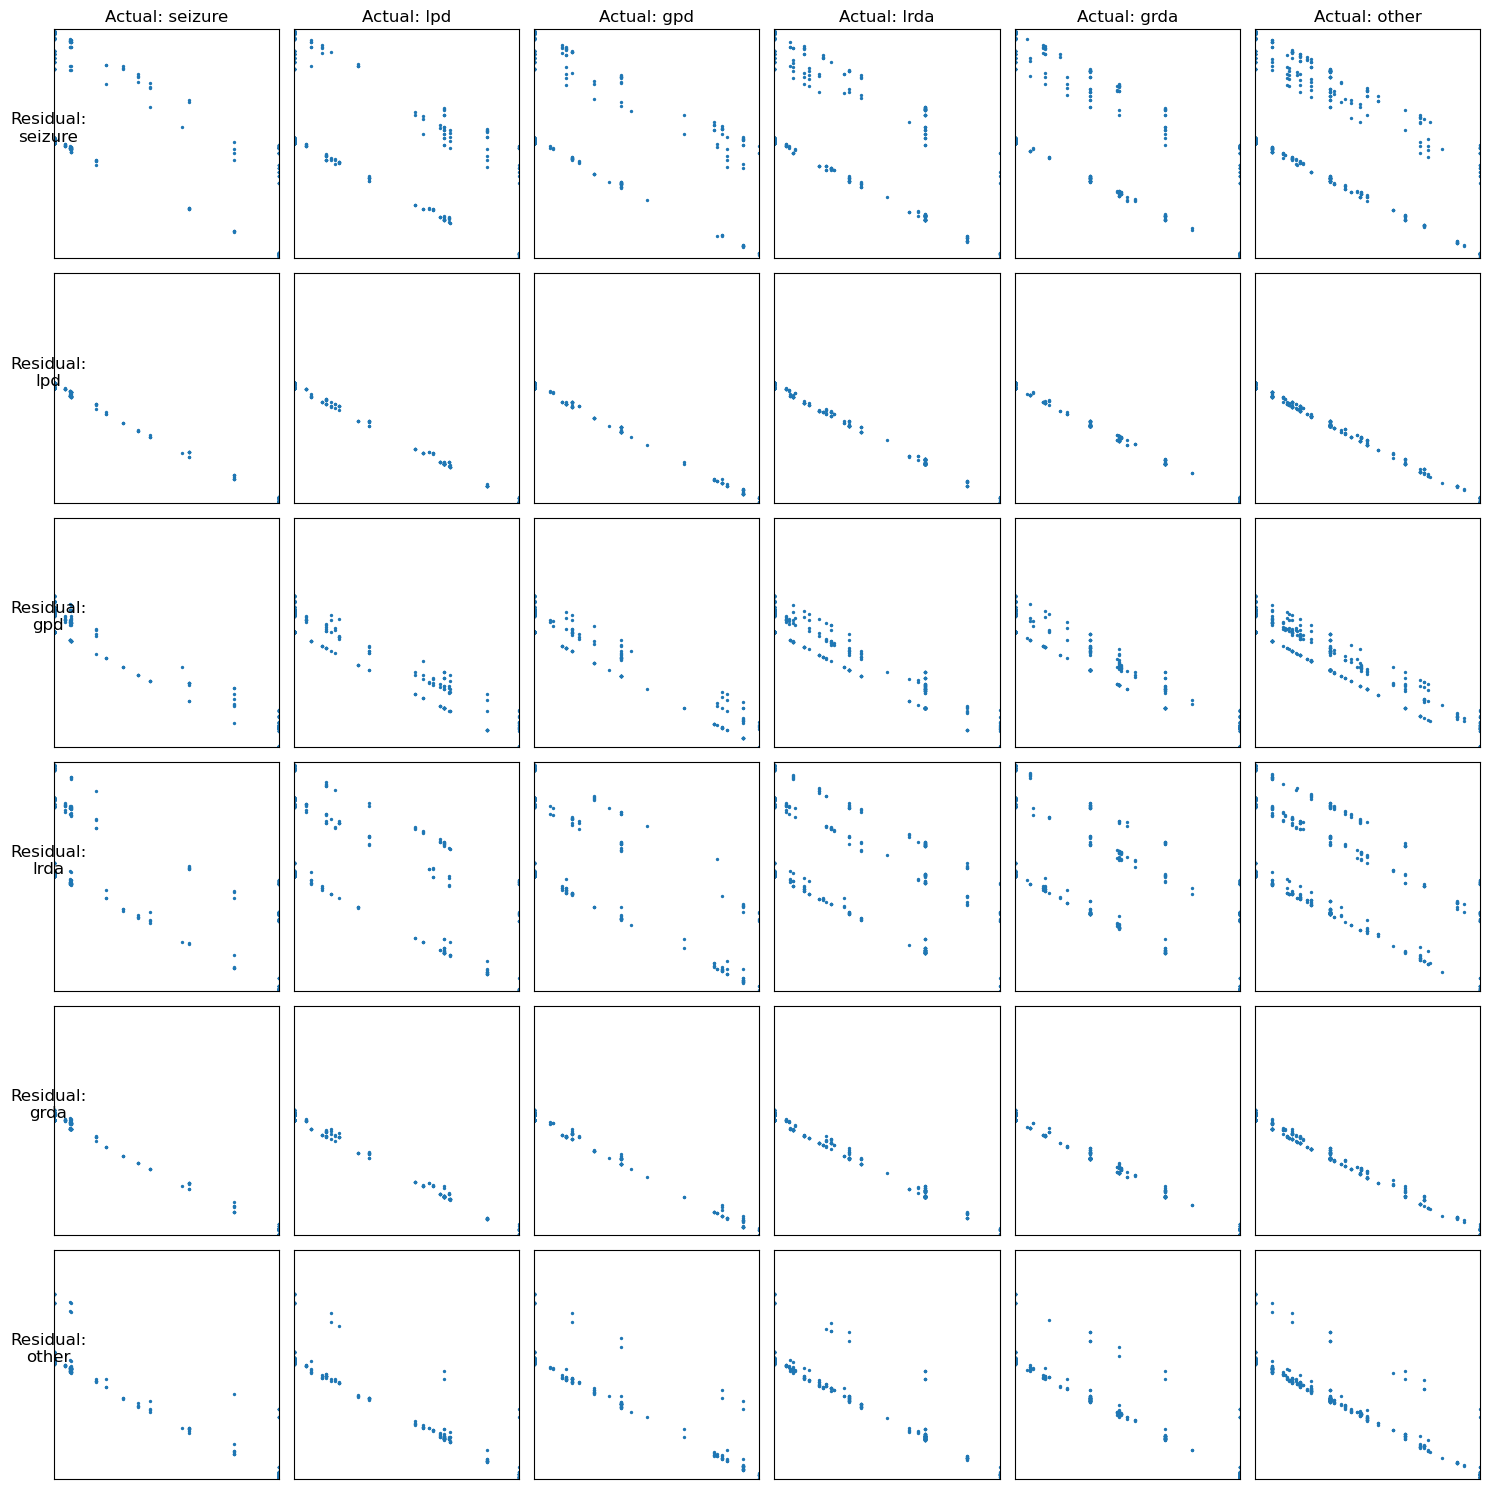

In [55]:
fig, axs = plt.subplots(6, 6, figsize=(15,15))
for row in range(6):
    for col in range(6):
        ax = axs[row][col]
        residual = valid_with_preds[class_names[row] + "_vote_pred"] - valid_with_preds[class_names[col] + "_vote_true"]
        ax.scatter(valid_with_preds[class_names[col] + "_vote_true"], residual, s=2)
        ax.set_ylim([-1, 1])
        ax.set_xlim([0, 1])
        ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
for ax, name in zip(axs[0], class_names):
    ax.set_title("Actual: " + name)

for ax, name in zip(axs[:, 0], class_names):
    ax.set_ylabel("Residual: " + name, rotation=90, size='large')
fig.suptitle("Residual vs. actual plot")
plt.tight_layout()